## Training of the neural network for the X-ray reconstruction

In the following notebook, an hexsample simulation will be extracted, preprocessed and used for training a neural network for inferring the X-ray energy and its hit position.

In [81]:
import os

import numpy as np

# importing the necessary keras modules for model creation, training and saving
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [82]:
# importing the custom libraries
from xrayreco.preprocessing import Xraydata
from hexsample.fileio import ReconInputFile

In [83]:
# Loading an hexsample simulation and storing its content into an Xraydata object
file_path = '/Users/chiara/hexsampledata/hxsim_20ENC_01srcsigma_continuumspectrum.h5'
data = Xraydata(file_path)

>>> Opening input file /Users/chiara/hexsampledata/hxsim_20ENC_01srcsigma_continuumspectrum.h5...
>>> File type: FileType.DIGI


In [84]:
# The Xraydata object contains methods for preprocessing that give the input and training output for the NN
input_data = data.input_events_data()
# Obtaining training output data from MC truth
target_data = data.target_data()

1000000it [00:35, 27860.79it/s]


In [85]:
# Printing the input data of the first event and the shape of the overall input
print(input_data[1])
print(input_data.shape)

[[ 2.19400000e+03  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.00000000e-03  5.19615242e-03]
 [ 0.00000000e+00  6.00000000e-03  0.00000000e+00]
 [ 0.00000000e+00  3.00000000e-03 -5.19615242e-03]
 [ 0.00000000e+00 -3.00000000e-03 -5.19615242e-03]
 [ 8.00000000e+00 -6.00000000e-03  0.00000000e+00]
 [ 3.00000000e+00 -3.00000000e-03  5.19615242e-03]]
(1000000, 7, 3)


As we can see, the input data is a numpy array of shape (n, 7, 3), where:
- n is the number of simulated events;
- 7 is the number of pixels of every event track;
- 3 is the number of informations contained in every pixel: (pha, x, y).  
**NB:** the coordinates x,y are _with respect to the pixel with highest signal_! That means that for every datum, the first coordinates will always be (0,0).

In [86]:
# Printing the target array of the first event and the shape of the overall target array
print(f'Energy = {target_data[0][0]}')
print(f'Hit coordinates wrt central px : ({target_data[0][1:]})')

Energy = 8563.998046875
Hit coordinates wrt central px : ([-0.00143402  0.00045931])


Text(0.5, 0, 'X-ray energy [eV]')

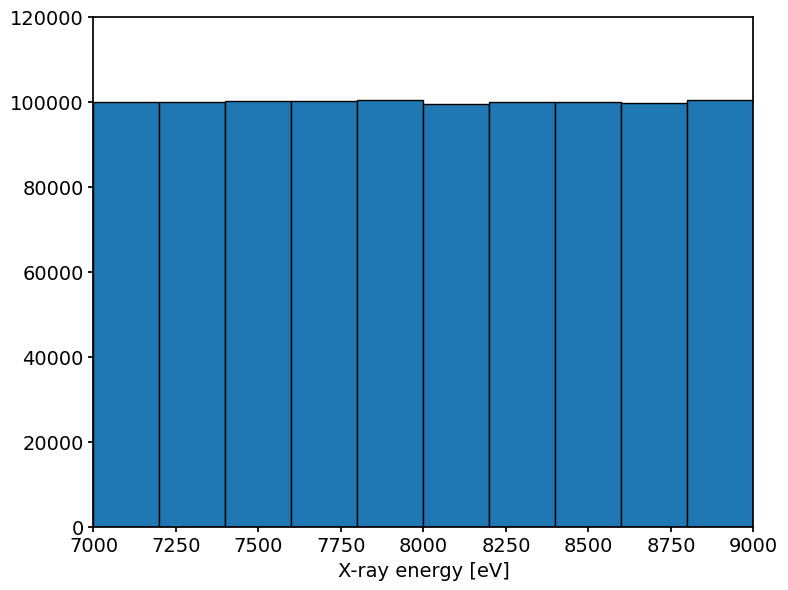

In [87]:
# Selecting the only energies
target_data[:,0]
plt.hist(target_data[:,0])
plt.xlabel('X-ray energy [eV]')

[Text(0.5, 0, '$y-y_{max}$')]

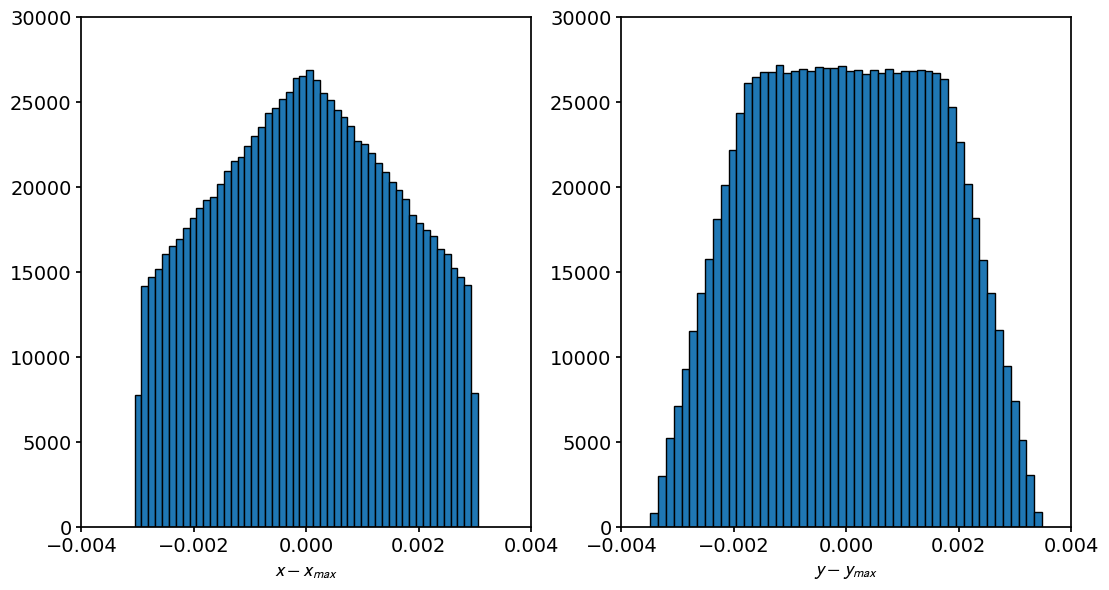

In [88]:
# Plotting the x and y target distribution
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
ax1.hist(target_data[:,1], bins=50)
ax1.set(xlabel=r'$x-x_{max}$')
ax2.hist(target_data[:,2], bins=50)
ax2.set(xlabel=r'$y-y_{max}$')


We can see that the distribution of x truncates on both sides at $\frac{p}{2}$ (the pitch of all the analyzed simulation is fixed to 60 $\mu$m). This makes sense: the x-ray hit position always lies on the pixel where the highest charge has been collected.  
The asymmetry between x and y is due to the different sizes of the hexagon on the two directions. In particular, for the `EVEN_R` layout, the pitch refers to half the x-direction dimension, that is 30 $\mu \text{m}$ , whereas the y-direction is given by $\frac{2}{\sqrt{3}} \cdot \frac{p}{2}$, that is 34.6 $\mu \text{m}$ .

In [89]:
print(input_data.shape)

(1000000, 7, 3)


In [90]:
# Standardizing input data
# In this particular case, a MinMax scaler makes more sense.
scaler = MinMaxScaler()
X = scaler.fit_transform(input_data.reshape(-1, input_data.shape[-1])).reshape(input_data.shape)

In [92]:
# Printing the first two rescaled events
X[0:2]

array([[[9.13453973e-01, 5.00000000e-01, 5.00000000e-01],
        [1.96695515e-03, 7.50000000e-01, 1.00000000e+00],
        [0.00000000e+00, 1.00000000e+00, 5.00000000e-01],
        [0.00000000e+00, 7.50000000e-01, 0.00000000e+00],
        [0.00000000e+00, 2.50000000e-01, 0.00000000e+00],
        [7.08103855e-03, 9.21485110e-15, 5.00000000e-01],
        [7.86782061e-04, 2.50000000e-01, 1.00000000e+00]],

       [[8.63099921e-01, 5.00000000e-01, 5.00000000e-01],
        [0.00000000e+00, 7.50000000e-01, 1.00000000e+00],
        [0.00000000e+00, 1.00000000e+00, 5.00000000e-01],
        [0.00000000e+00, 7.50000000e-01, 0.00000000e+00],
        [0.00000000e+00, 2.50000000e-01, 0.00000000e+00],
        [3.14712825e-03, 9.21485110e-15, 5.00000000e-01],
        [1.18017309e-03, 2.50000000e-01, 1.00000000e+00]]])

In [ ]:
# Creating the FFNN model

# Defining the input layer
input = Input(shape=(7,3))
# Flattening the input (by now no convolutional layer - data are already pretty compressed)
hidden = Flatten()(input)
# Creating some dense layers - the activation is always relu for hidden layers
hidden = Dense(20, activation='relu')(hidden)
hidden = Dense(50, activation='relu')(hidden)
hidden = Dense(50, activation='relu')(hidden)
# Splitting the NN in two 'branches', one for the energy, one for
# the position
hidden_e = Dense(50, activation='relu')(hidden)
hidden_e = Dense(10, activation='relu')(hidden_e)
output_energy = Dense(1, activation='linear')(hidden_e)

hidden_xy = Dense(50, activation='relu')(hidden)
hidden_xy = Dense(50, activation='relu')(hidden_xy)
hidden_xy = Dense(30, activation='relu')(hidden_xy)
output_hit_coordinates = Dense(2, activation='linear')(hidden_xy)

# Defining the outputs
outputs = [output_energy, output_hit_coordinates]
# Defining the loss functions - both MSE for regression
losses = ['MSE', 'MSE']

# Creating the model and compiling it
model = Model(inputs=input, outputs=outputs)

model.compile(loss=losses, optimizer='adam') # those are standard params, see if any better

# Printing the summary
model.summary()


In [ ]:
# Defining the path and directory for checkpoints that save the model's weights.
checkpoint_path = "../training_uniform/cp_uniform.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

In [ ]:
# Train the model with the new callback
history=model.fit(X, [target_data[:,0],target_data[:,1:]], epochs=50, validation_split=0.2, callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

In [ ]:
print(history.history.keys())
plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

In [ ]:
# Load the previously saved weights
model.load_weights(checkpoint_path)

In [ ]:
new_data = Xraydata('/Users/chiara/hexsampledata/hxsim_20ENC_01srcsigma_continuumspectrum_test.h5')

In [ ]:
# Extrapolating input data and predicting the target using the NN
new_input_data = new_data.input_events_data()
new_target_data = new_data.target_data()


In [ ]:
x_max, y_max = new_data.highest_pixel_coordinates()

In [ ]:
# Opening the reconstructed file relative to the test data
recon_file = ReconInputFile('/Users/chiara/hexsampledata/hxsim_20ENC_01srcsigma_continuumspectrum_test_recon.h5')
# Obtaining the reconstructed energy
recon_energies = recon_file.column('energy')
recon_x = recon_file.column('posx')
recon_y = recon_file.column('posy')

Predicting the data using the NN

In [ ]:
# Pay attention, before prediction, the test data need to be 
# scaled (with the same scale as the training data!!!)!
X_test = scaler.fit_transform(new_input_data.reshape(-1, new_input_data.shape[-1])).reshape(new_input_data.shape)
predicted_data = model.predict(X_test)

In [ ]:
print(predicted_data)

In [ ]:
print(predicted_data[0])

In [ ]:
new_target_data[:,0]

In [ ]:
plt.hist(recon_energies, 20, label='Recon')
plt.hist(predicted_data[0], 20, label='NN inference')
plt.hist(new_target_data[:,0], 20, alpha=0.5, label='True energies')

plt.legend()

In [ ]:
# Printing the x positions wrt the central px
print(predicted_data[1][:,0])

In [ ]:
# Printing the y positions wrt the central px
print(predicted_data[1][:,1])

The net is not able to learn the position by now. 

In [ ]:
# Plotting the x position distribution and the relative recon
plt.figure()
plt.hist(recon_x - x_max, 100, label='Recon')
#plt.hist(predicted_data[1][:,0], 10, alpha=0.2, label='NN predicted')
plt.hist(new_target_data[:,1], 100, alpha=0.2, label='MC truth')

plt.legend()

The recon peak makes sense: those could be the tracks with single signal pixel, which makes the computation of the barycenter impossible.

In [ ]:
plt.figure()
plt.hist(recon_y - y_max, 50, label='Recon')
plt.hist(new_target_data[:,2], 50, alpha=0.2, label='MC truth')
#plt.hist(predicted_data[1][:,1], 30, alpha=0.2, label='NN predicted')

plt.legend()

In order to see if there is more margin on energy resolution, I incremented the number of parameters for the NN.

In [ ]:
# Creating the FFNN model

# Defining the input layer
input = Input(shape=(7,3))
# Flattening the input (by now no convolutional layer - data are already pretty compressed)
hidden = Flatten()(input)
# Creating some dense layers - the activation is always relu for hidden layers
hidden = Dense(100, activation='relu')(hidden)
hidden = Dense(100, activation='relu')(hidden)
hidden = Dense(100, activation='relu')(hidden)
# Splitting the NN in two 'branches', one for the energy, one for
# the position
hidden_e = Dense(50, activation='relu')(hidden)
hidden_e = Dense(50, activation='relu')(hidden_e)
hidden_e = Dense(10, activation='relu')(hidden_e)
output_energy = Dense(1, activation='linear')(hidden_e)

hidden_xy = Dense(50, activation='relu')(hidden)
hidden_xy = Dense(50, activation='relu')(hidden_xy)
hidden_xy = Dense(30, activation='relu')(hidden_xy)
output_hit_coordinates = Dense(2, activation='linear')(hidden_xy)

# Defining the outputs
outputs = [output_energy, output_hit_coordinates]
# Defining the loss functions - both MSE for regression
losses = ['MSE', 'MSE']

# Creating the model and compiling it
model2 = Model(inputs=input, outputs=outputs)

model2.compile(loss=losses, optimizer='adam') # those are standard params, see if any better

# Printing the summary
model2.summary()


In [ ]:
# Defining the path and directory for checkpoints that save the model's weights.
checkpoint_path = "../training_uniform/cp_uniform2.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

In [ ]:
# Train the model with the new callback
history=model2.fit(X, [target_data[:,0],target_data[:,1:]], epochs=50, validation_split=0.2, callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

In [ ]:
# Pay attention, before prediction, the test data need to be 
# scaled (with the same scale as the training data!!!)!
X_test = scaler.fit_transform(new_input_data.reshape(-1, new_input_data.shape[-1])).reshape(new_input_data.shape)
predicted_data2 = model2.predict(X_test)

In [ ]:
plt.hist(recon_energies, 20)
plt.hist(predicted_data[0], 20, alpha=0.5, color='red')
plt.hist(predicted_data2[0], 20, alpha=0.5, color='yellow')
plt.hist(new_target_data[:,0], 20, alpha=0.5, color='green')

Stratifying the model reduced the energy resolution.
Next steps:
- Same but with bigger training set [x] -> didn't really changed but the bias on beta peak looks diminished.
- Now it is necessary to understand why the position is not correctly reconstructed []
- When the NN has been chosen, it is time to test it on a bigger dataset having several values of noise ENC []